In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from imutils import paths
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import matplotlib.axes._axes as axes
sns.set()

In [3]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor, \
    AspectAwarePreprocessor, MeanSubtractionPreProcessor, SimplePreProcessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.io import HDF5DatasetGenerator
from loader_util.nn.conv import FCHeadNet
from loader_util.callbacks import TrainingMonitor, EpochCheckpoint
##
from tensorflow.keras.layers import Conv2D, Activation, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler

In [4]:
# construct the train image generator
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode='nearest')

In [5]:
batch_size = 64
epoch_num = 100

# initialise the image preprocessors
sp = SimplePreProcessor(width=224, height=224)
iap = ImageToArrayPreprocessor()

In [6]:
# initialise the data paths

dbBase = r"/home/mhasan3/Desktop/WorkFolder/mokn_10class_data/"
dbTrainPath = f"{dbBase}//train_cad_10class.hdf5"
dbValidPath = f"{dbBase}//validate_cad_10class.hdf5"

# get the no. of classes
trainFile = h5py.File(name=dbTrainPath, mode="r")
class_num = len(list(np.unique(trainFile["labels"])))
print(f"Total no. of classes in dataset: {class_num}")

Total no. of classes in dataset: 10


In [7]:
# consider class weight discrepency
le = LabelEncoder()
labels = le.fit_transform(trainFile["labels"])
encoded_labels = to_categorical(labels)

classLabels = le.classes_
classTotals = encoded_labels.sum(axis=0) # type: np.ndarray
classWeight = classTotals.max() / classTotals

print(f"ClassLabels: {classLabels}")
print(f"ClassWeights: {classWeight}")

ClassLabels: [0 1 2 3 4 5 6 7 8 9]
ClassWeights: [  8.466549    1.4625913   7.706731    1.5710552   1.          9.618
   1.3455513 282.88235    98.14286     1.8439417]


In [8]:
# initialise the train and valid generators
trainGen = HDF5DatasetGenerator(dbPath=dbTrainPath,
                                batchSize=batch_size,
                                preprocessors=[sp, iap],
                                classes=class_num,
                                aug=aug)

valGen = HDF5DatasetGenerator(dbPath=dbValidPath,
                              batchSize=batch_size,
                              preprocessors=[sp, iap],
                              classes=class_num)

In [9]:
# define the Learning Rate Scheduler

initial_rate = 5e-3

def poly_decay(epoch):
    max_epochs = epoch_num
    baseLR = initial_rate
    power = 1.0
    
    alpha = baseLR * (1 - (epoch / float(max_epochs))) ** power
    return alpha

In [10]:
# load the VGG16 network ensuring the head FC layer sets are left off
baseModel = VGG16(weights='imagenet', include_top=False,
                  input_tensor=Input(shape=(224, 224, 3))) # type: Model

# initialise the new head of the network, a set of FC layers followed by
# softmax
headModel = FCHeadNet.builld(baseModel, classes=class_num, D=[1024, 512, 256]) # type: Model

# place the head FC model on top of the base model - this will be the actual
# model to train
model = Model(inputs=baseModel.input, outputs=headModel)

Instructions for updating:
Colocations handled automatically by placer.
BaseModel Out Shape:  (?, 7, 7, 512)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [12]:
# loop over all the layers in the base model and freeze them
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
# compile and optimise model
opt = SGD(lr=initial_rate)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# construct callbacks
path = os.path.sep.join([dbBase, f'{os.getpid()}.png'])
callbacks = [TrainingMonitor(path),
             LearningRateScheduler(poly_decay),
             EpochCheckpoint(outputPath=dbBase)]

In [14]:
# train the head for few epochs
H = model.fit_generator(
    trainGen.generator(),
    steps_per_epoch=trainGen.numImages//batch_size,
    validation_data=valGen.generator(),
    validation_steps=valGen.numImages//batch_size,
    epochs=epoch_num,
    max_queue_size=20,
    verbose=1,
    callbacks=callbacks,
    class_weight=classWeight
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
298/298 [==============================] - 341s 1s/step - loss: 1.2066 - acc: 0.5955 - val_loss: 0.6619 - val_acc: 0.7757
Epoch 2/100
298/298 [==============================] - 359s 1s/step - loss: 0.7624 - acc: 0.7537 - val_loss: 0.5042 - val_acc: 0.8222
Epoch 3/100
298/298 [==============================] - 351s 1s/step - loss: 0.6213 - acc: 0.7951 - val_loss: 0.4185 - val_acc: 0.8499
Epoch 4/100
298/298 [==============================] - 352s 1s/step - loss: 0.5538 - acc: 0.8142 - val_loss: 0.3423 - val_acc: 0.8788
Epoch 5/100
298/298 [==============================] - 341s 1s/step - loss: 0.5001 - acc: 0.8281 - val_loss: 0.3317 - val_acc: 0.8769
Epoch 6/100
298/298 [==============================] - 326s 1s/step - loss: 0.4619 - acc: 0.8413 - val_loss: 0.3146 - val_acc: 0.8811
Epoch 7/100
298/298 [==============================] - 318s 1s/step - loss: 0.4360 - acc: 0.8496 - val_loss: 0.3003 - val_acc: 0.8908
Epoch 8/100
29

Epoch 37/100
298/298 [==============================] - 390s 1s/step - loss: 0.2122 - acc: 0.9273 - val_loss: 0.1375 - val_acc: 0.9517
Epoch 38/100
298/298 [==============================] - 363s 1s/step - loss: 0.2177 - acc: 0.9232 - val_loss: 0.1393 - val_acc: 0.9489
Epoch 39/100
298/298 [==============================] - 342s 1s/step - loss: 0.2144 - acc: 0.9241 - val_loss: 0.1363 - val_acc: 0.9494
Epoch 40/100
298/298 [==============================] - 343s 1s/step - loss: 0.2063 - acc: 0.9280 - val_loss: 0.1337 - val_acc: 0.9521
Epoch 41/100
298/298 [==============================] - 334s 1s/step - loss: 0.2075 - acc: 0.9271 - val_loss: 0.1332 - val_acc: 0.9515
Epoch 42/100
298/298 [==============================] - 351s 1s/step - loss: 0.2076 - acc: 0.9274 - val_loss: 0.1307 - val_acc: 0.9549
Epoch 43/100
298/298 [==============================] - 370s 1s/step - loss: 0.2010 - acc: 0.9307 - val_loss: 0.1303 - val_acc: 0.9546
Epoch 44/100
298/298 [==============================] -

Epoch 74/100
298/298 [==============================] - 318s 1s/step - loss: 0.1604 - acc: 0.9452 - val_loss: 0.1042 - val_acc: 0.9636
Epoch 75/100
298/298 [==============================] - 372s 1s/step - loss: 0.1626 - acc: 0.9446 - val_loss: 0.1039 - val_acc: 0.9638
Epoch 76/100
298/298 [==============================] - 371s 1s/step - loss: 0.1619 - acc: 0.9445 - val_loss: 0.1015 - val_acc: 0.9649
Epoch 77/100
298/298 [==============================] - 350s 1s/step - loss: 0.1584 - acc: 0.9453 - val_loss: 0.1036 - val_acc: 0.9631
Epoch 78/100
298/298 [==============================] - 358s 1s/step - loss: 0.1556 - acc: 0.9473 - val_loss: 0.1010 - val_acc: 0.9653
Epoch 79/100
298/298 [==============================] - 353s 1s/step - loss: 0.1570 - acc: 0.9472 - val_loss: 0.1004 - val_acc: 0.9649
Epoch 80/100
298/298 [==============================] - 319s 1s/step - loss: 0.1545 - acc: 0.9465 - val_loss: 0.1008 - val_acc: 0.9622
Epoch 81/100
298/298 [==============================] -

In [15]:
model.save(f"{dbBase}//cadrepo_10class_model.pt")

In [ ]:
import h5py
from tensorflow.keras.utils import to_categorical
validDB = h5py.File(dbValidPath, mode="r")
testx = validDB["images"]
testy = to_categorical(validDB["labels"], class_num)

In [ ]:
preds = model.predict(testx, batch_size=batch_size)

In [ ]:
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy.argmax(axis=1),
                 preds.argmax(axis=1))
cm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [ ]:
class_names = [
    'Assembly',
    'Bearings',
    'Bolts',
    'Brackets',
    'Bushing',
    'Bushing_Liners',
    'Casting',
    'Collage',
    'Collets',
    'Forming'
]

In [ ]:
print_confusion_matrix(cm, class_names=class_names)

In [19]:
preds = model.predict(testx, batch_size=batch_size)

array([[7.8120948e-08, 5.2015114e-10, 2.1041895e-08, ..., 7.1358492e-08,
        5.3835976e-08, 8.2936574e-05],
       [9.1015778e-07, 1.6525485e-07, 8.6915591e-08, ..., 2.4793183e-06,
        9.2735434e-07, 9.2613467e-05],
       [1.0536983e-07, 3.9073449e-12, 3.6103056e-09, ..., 1.0705749e-08,
        1.7865561e-09, 1.4722654e-04],
       ...,
       [1.2451154e-06, 3.6845258e-09, 3.0475496e-07, ..., 2.0902679e-07,
        1.5291604e-07, 6.0345149e-03],
       [2.7174092e-05, 1.8306363e-04, 3.1854997e-06, ..., 2.0682257e-04,
        4.6612160e-05, 1.1635312e-04],
       [8.9778121e-07, 1.8688555e-08, 3.2679662e-08, ..., 1.5470148e-06,
        1.5741876e-06, 4.6884536e-04]], dtype=float32)

In [21]:
print(classification_report(testy.argmax(axis=1),
                            preds.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       243
           1       1.00      1.00      1.00      1410
           2       1.00      1.00      1.00       267
           3       0.99      1.00      0.99      1313
           4       0.99      1.00      0.99      2061
           5       0.98      1.00      0.99       214
           6       0.94      0.91      0.92      1532
           7       1.00      0.29      0.44         7
           8       1.00      1.00      1.00        21
           9       0.90      0.91      0.91      1118

    accuracy                           0.97      8186
   macro avg       0.97      0.90      0.92      8186
weighted avg       0.97      0.97      0.97      8186



In [22]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testy.argmax(axis=1),
                 preds.argmax(axis=1))
cm

array([[ 213,    0,    0,    0,    0,    0,   22,    0,    0,    8],
       [   0, 1410,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,  267,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 1311,    0,    0,    2,    0,    0,    0],
       [   0,    0,    0,    0, 2057,    0,    4,    0,    0,    0],
       [   0,    0,    0,    0,    0,  214,    0,    0,    0,    0],
       [   8,    2,    0,    6,   11,    2, 1398,    0,    0,  105],
       [   0,    1,    0,    0,    0,    1,    2,    2,    0,    1],
       [   0,    0,    0,    0,    0,    0,    0,    0,   21,    0],
       [   6,    0,    1,   10,   12,    1,   67,    0,    0, 1021]])

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [26]:
class_names = [
    'Assembly',
    'Bearings',
    'Bolts',
    'Brackets',
    'Bushing',
    'Bushing_Liners',
    'Casting',
    'Collage',
    'Collets',
    'Forming'
]

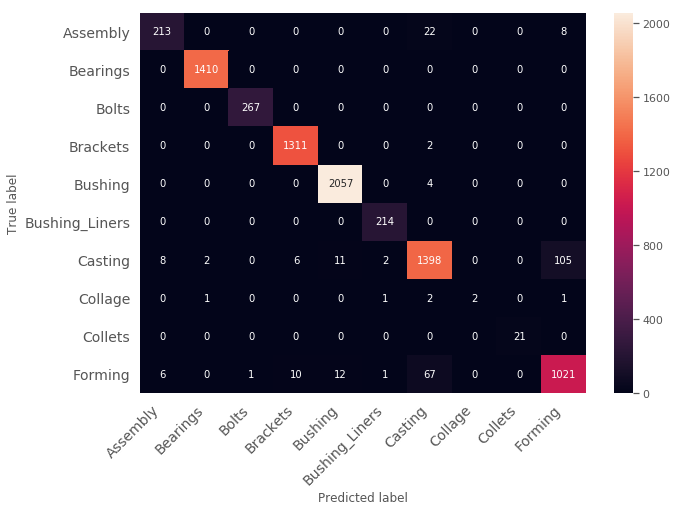

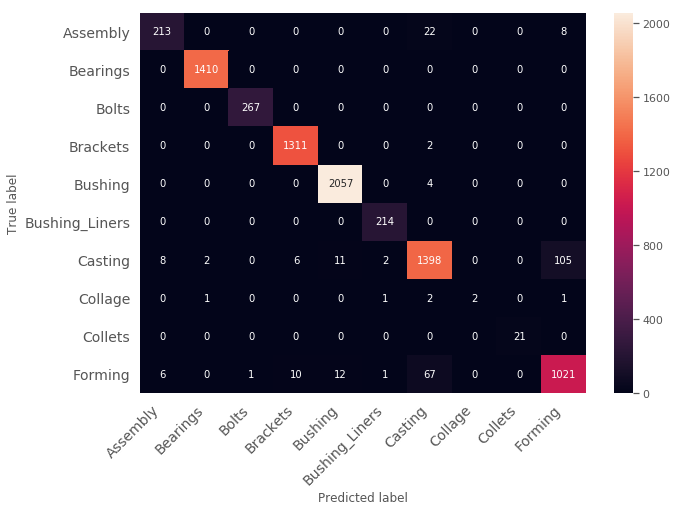

In [27]:
print_confusion_matrix(cm, class_names=class_names)